# 6. Advanced Modeling and Deployment

## 6.1 Using Advanced Features from src Modules

We'll leverage the structured modules for advanced hyperparameter tuning, feature importance analysis, and model deployment using the existing `src.modeling`, `src.evaluation`, and `src.feature_engineering` modules.

### **Initialize Advanced Modeling Pipeline**

In [1]:
import sys
sys.path.append('../src')
from modeling import ModelTrainer, prepare_training_data
from evaluation import ModelEvaluator, evaluate_model_comprehensive
from feature_engineering import FeatureEngineer
from config import DATA_PATHS, RIDGE_PARAMS, LASSO_PARAMS, ELASTICNET_PARAMS, CV_FOLDS
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Initialize components for advanced modeling
trainer = ModelTrainer()
evaluator = ModelEvaluator()
feature_engineer = FeatureEngineer()

# Load prepared data
X, y = prepare_training_data()
print(f"Data loaded for advanced modeling: {X.shape}")

Data loaded for advanced modeling: (1460, 215)


## 6.2 Advanced Hyperparameter Tuning

Using the built-in hyperparameter tuning methods from `ModelTrainer` with configuration from `src.config`:

In [2]:
# Split data for hyperparameter tuning
X_train, X_test, y_train, y_test = trainer.split_data(X, y)

# Tune Ridge hyperparameters using config parameters
print("Tuning Ridge hyperparameters...")
ridge_grid = trainer.tune_ridge_hyperparameters(X_train, y_train, RIDGE_PARAMS)
print(f"Best Ridge params: {ridge_grid.best_params_}")
print(f"Best Ridge CV score: {-ridge_grid.best_score_:.4f}")

# Tune Lasso hyperparameters
print("\nTuning Lasso hyperparameters...")
lasso_grid = trainer.tune_lasso_hyperparameters(X_train, y_train, LASSO_PARAMS)
print(f"Best Lasso params: {lasso_grid.best_params_}")
print(f"Best Lasso CV score: {-lasso_grid.best_score_:.4f}")

# Tune Elastic Net hyperparameters
print("\nTuning Elastic Net hyperparameters...")
elastic_grid = trainer.tune_elasticnet_hyperparameters(X_train, y_train, ELASTICNET_PARAMS)
print(f"Best Elastic Net params: {elastic_grid.best_params_}")
print(f"Best Elastic Net CV score: {-elastic_grid.best_score_:.4f}")

Tuning Ridge hyperparameters...
Best Ridge params: {'alpha': 50}
Best Ridge CV score: 0.1457

Tuning Lasso hyperparameters...
Best Lasso params: {'alpha': 0.001}
Best Lasso CV score: 0.1453

Tuning Elastic Net hyperparameters...
Best Elastic Net params: {'alpha': 0.01, 'l1_ratio': 0.1}
Best Elastic Net CV score: 0.1451


## 6.3 Evaluate Tuned Models

Compare the performance of hyperparameter-tuned models:

In [4]:
# Evaluate tuned models with inverse transformation
tuned_results = {}

# Ridge (tuned)
y_pred_ridge_tuned = ridge_grid.best_estimator_.predict(X_test)
if y_train.name == 'SalePrice_log':
    y_pred_ridge_tuned = feature_engineer.inverse_log_transform(y_pred_ridge_tuned)
    y_test_eval = feature_engineer.inverse_log_transform(y_test)
else:
    y_test_eval = y_test
tuned_results['Ridge (Tuned)'] = evaluator.calculate_metrics(y_test_eval, y_pred_ridge_tuned)

# Lasso (tuned)
y_pred_lasso_tuned = lasso_grid.best_estimator_.predict(X_test)
if y_train.name == 'SalePrice_log':
    y_pred_lasso_tuned = feature_engineer.inverse_log_transform(y_pred_lasso_tuned)
tuned_results['Lasso (Tuned)'] = evaluator.calculate_metrics(y_test_eval, y_pred_lasso_tuned)

# Elastic Net (tuned)
y_pred_elastic_tuned = elastic_grid.best_estimator_.predict(X_test)
if y_train.name == 'SalePrice_log':
    y_pred_elastic_tuned = feature_engineer.inverse_log_transform(y_pred_elastic_tuned)
tuned_results['Elastic Net (Tuned)'] = evaluator.calculate_metrics(y_test_eval, y_pred_elastic_tuned)

# Compare tuned models
tuned_comparison = evaluator.compare_models(tuned_results, metric='RMSE')
print("Tuned Model Comparison:")
tuned_comparison

Tuned Model Comparison:


,RMSE,MAE,R2,MAPE,Median_AE,Mean_Percentage_Error
Lasso (Tuned),26274.761396,16528.773939,0.909996,9.974349,10901.385578,1.496824
Ridge (Tuned),26369.180371,16716.796720,0.909348,9.987193,10951.672055,1.476263
Elastic Net (Tuned),26674.384846,16788.195626,0.907237,10.076108,11243.761316,1.504214


## 6.4 Advanced Feature Importance Analysis

Using the `FeatureEngineer` and `ModelEvaluator` for comprehensive feature importance:

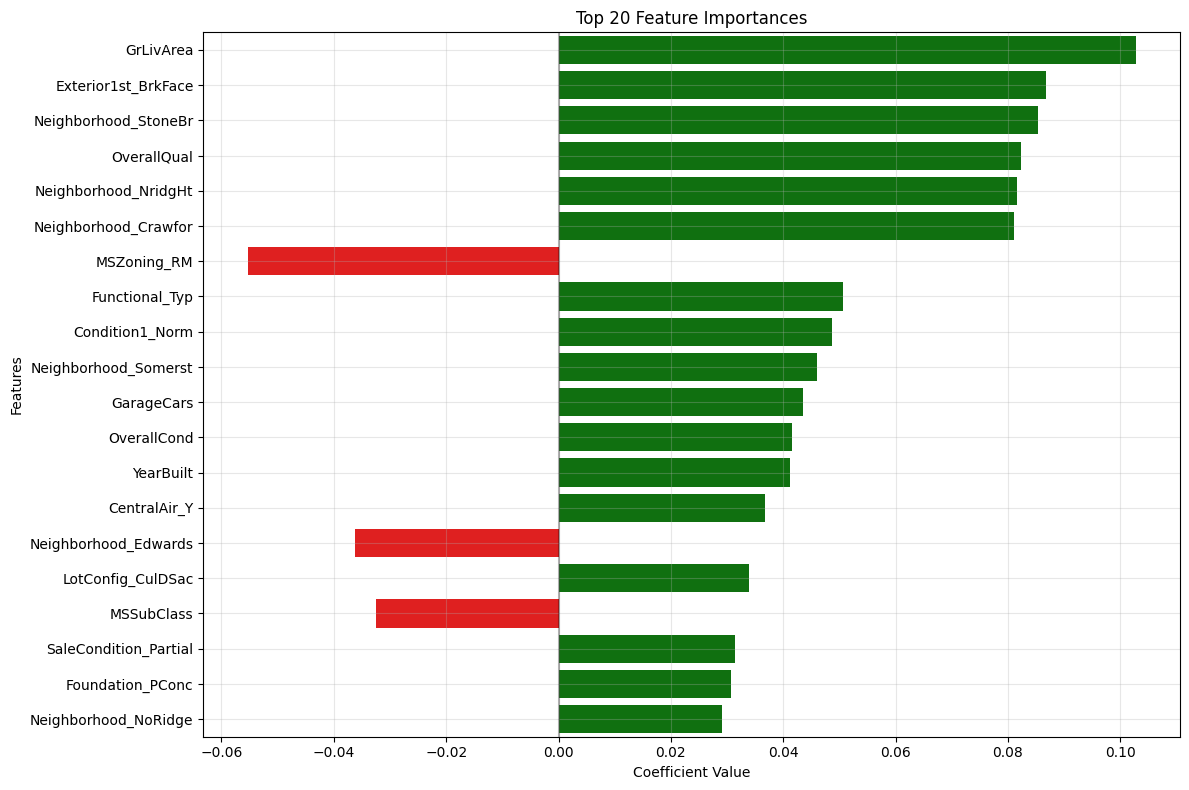

Top 10 most important features for Lasso (Tuned):
                  feature  coefficient
24              GrLivArea     0.102722
134   Exterior1st_BrkFace     0.086838
91   Neighborhood_StoneBr     0.085326
4             OverallQual     0.082308
85   Neighborhood_NridgHt     0.081577
75   Neighborhood_Crawfor     0.081104
53            MSZoning_RM    -0.055341
183        Functional_Typ     0.050682
95        Condition1_Norm     0.048623
90   Neighborhood_Somerst     0.045990


In [5]:
# Get feature importance for the best tuned model
best_model_name = tuned_comparison.index[0]  # Get best model name
if 'Ridge' in best_model_name:
    best_model = ridge_grid.best_estimator_
elif 'Lasso' in best_model_name:
    best_model = lasso_grid.best_estimator_
else:
    best_model = elastic_grid.best_estimator_

# Generate feature importance data
feature_importance_df = feature_engineer.get_feature_importance_data(
    best_model, X_train.columns.tolist()
)

# Plot feature importance using evaluator
evaluator.plot_feature_importance(
    feature_importance_df, 
    top_n=20,
    save_path="../reports/advanced_feature_importance.png"
)

print(f"Top 10 most important features for {best_model_name}:")
print(feature_importance_df.head(10))

## 6.5 Comprehensive Model Evaluation

Using the `evaluate_model_comprehensive` function for detailed analysis:

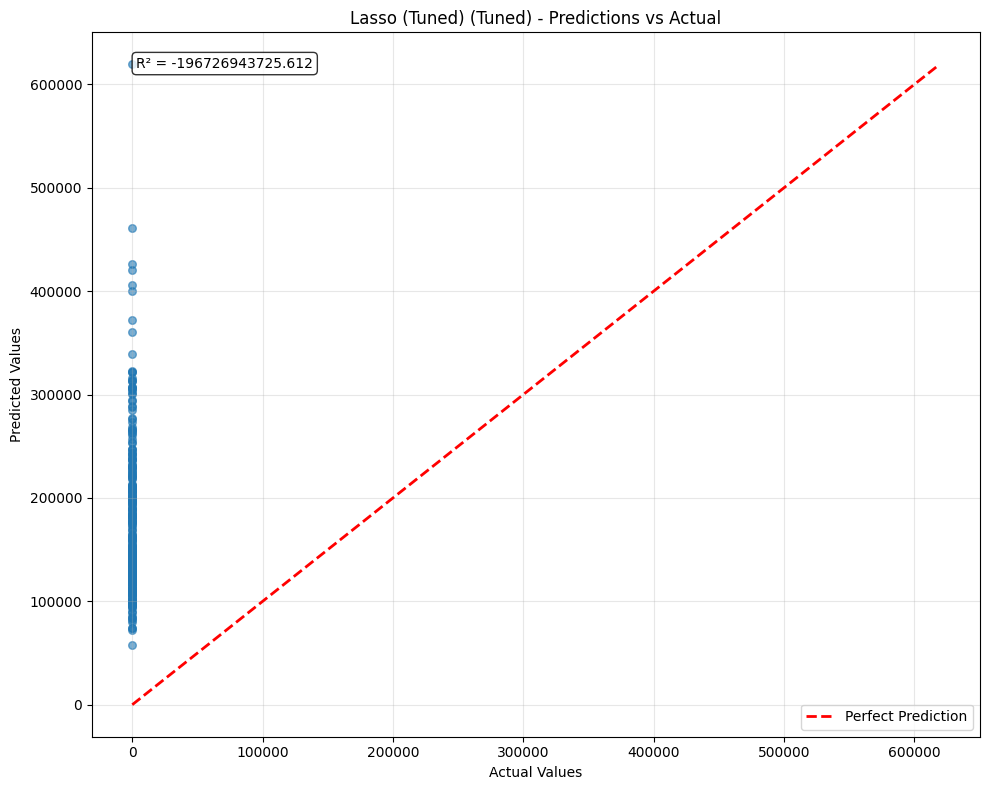

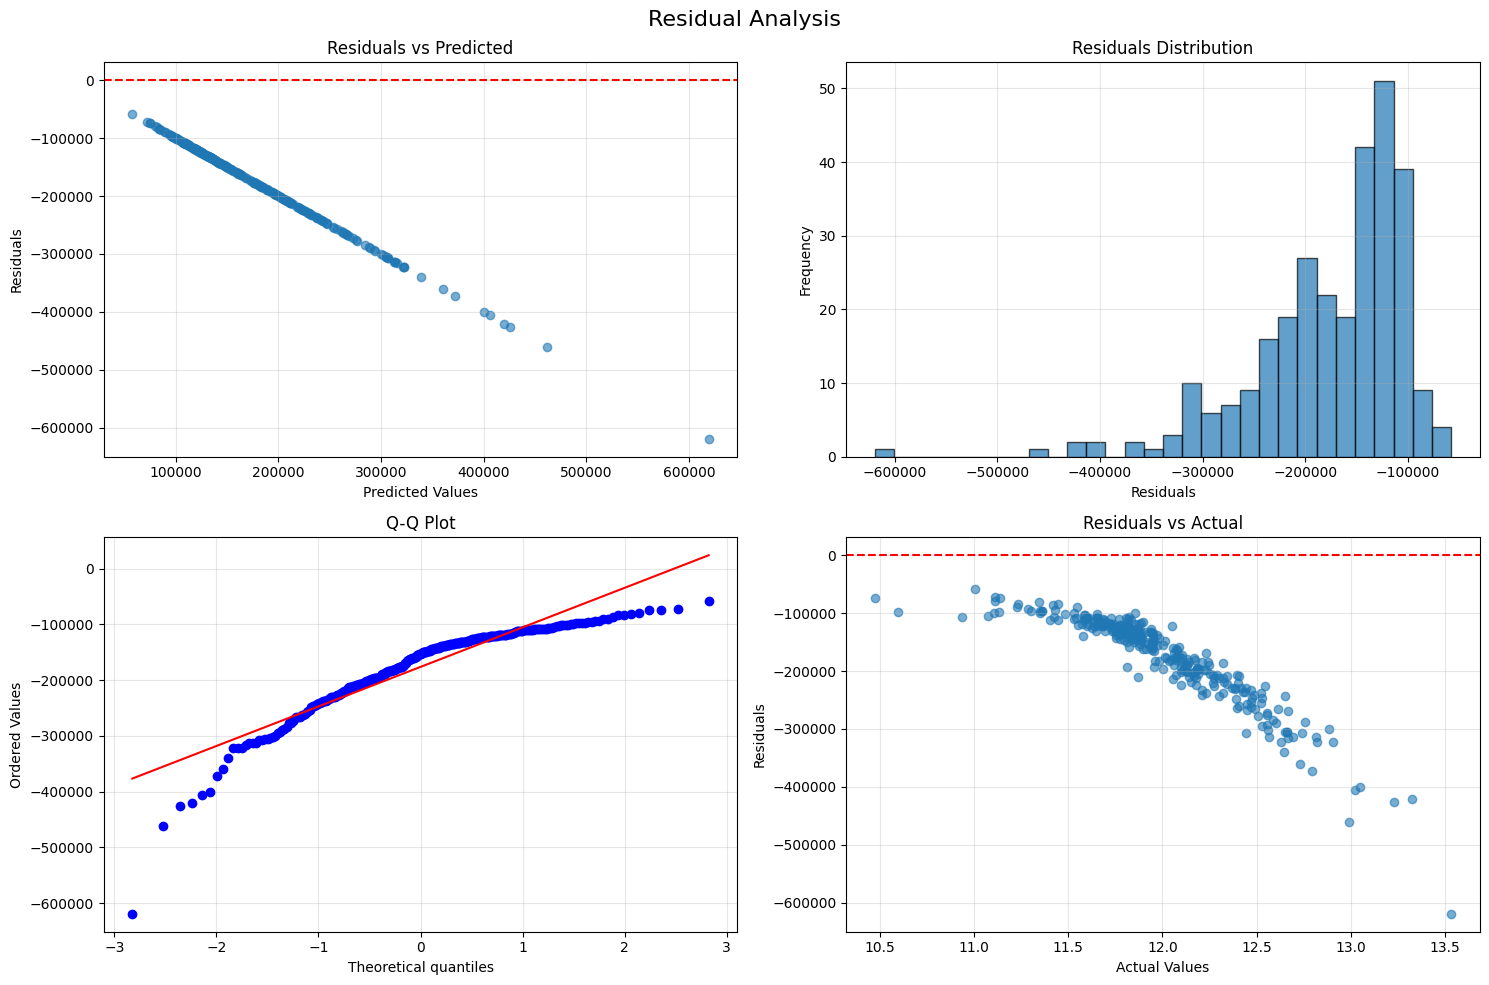


EVALUATION SUMMARY: Lasso (Tuned) (Tuned)

📊 PERFORMANCE METRICS:
  RMSE: $191,602.22
  MAE:  $176,175.58
  R²:   -196726943725.612
  MAPE: 1450028.27%

💼 BUSINESS IMPACT:
  Avg Absolute Error: $176,175.58
  Predictions within 5%: 0.0%
  Predictions within 10%: 0.0%
  Underpriced predictions: 0.0%

📈 RESIDUAL ANALYSIS:
  Mean residual: $-176,175.58
  Residual std: $75,323.13


Final Model Performance Summary:
Model: Lasso (Tuned)
RMSE: $191,602.22
R²: -196726943725.6119
MAPE: 1450028.27%


In [6]:
# Comprehensive evaluation of the best tuned model
best_report = evaluate_model_comprehensive(
    best_model, X_test, y_test,
    model_name=f"{best_model_name} (Tuned)",
    feature_engineer=feature_engineer,
    avg_house_price=180000,
    save_dir="../reports/advanced_evaluation"
)

# Show detailed metrics
print(f"\nFinal Model Performance Summary:")
print(f"Model: {best_model_name}")
print(f"RMSE: ${best_report['metrics']['RMSE']:,.2f}")
print(f"R²: {best_report['metrics']['R2']:.4f}")
print(f"MAPE: {best_report['metrics']['MAPE']:.2f}%")

## 6.6 Model Deployment Preparation

Using the `ModelTrainer.save_model` method for deployment-ready model persistence:

In [ ]:
# # Save the best tuned model for deployment
# deployment_model_path = trainer.save_model(
#     best_model, 
#     f"best_{best_model_name.lower().replace(' ', '_')}_tuned.pkl"
# )
# print(f"Deployment model saved to: {deployment_model_path}")

# # Also save the feature engineer for preprocessing
# import joblib
# feature_engineer_path = trainer.save_model(
#     feature_engineer, 
#     "feature_engineer.pkl"
# )
# print(f"Feature engineer saved to: {feature_engineer_path}")

Deployment model saved to: e:\Projects_3\Data Science\Regression\Housing Prices_2\models\best_lasso_(tuned)_tuned.pkl
Feature engineer saved to: e:\Projects_3\Data Science\Regression\Housing Prices_2\models\feature_engineer.pkl


## 6.7 Deployment Example

Example of how to use the saved models for prediction:

In [ ]:
# Example deployment function
def predict_housing_price(new_data, model_path, feature_engineer_path):
    """
    Example function for deployment prediction pipeline.
    
    Args:
        new_data: New housing data (DataFrame)
        model_path: Path to saved model
        feature_engineer_path: Path to saved feature engineer
    
    Returns:
        Predicted house prices
    """
    # Load saved components
    loaded_model = trainer.load_model(model_path)
    loaded_fe = trainer.load_model(feature_engineer_path)
    
    # Apply same preprocessing
    processed_data = loaded_fe.engineer_features(
        new_data,target_column=None, apply_log_target=False, scale_features=True
    )[0]  # Get engineered data only
    
    # Make predictions
    predictions_log = loaded_model.predict(processed_data)
    predictions = loaded_fe.inverse_log_transform(predictions_log)
    
    return predictions

# # Example usage (commented out to avoid errors):
# sample_prediction = predict_housing_price(
#     test_df, 
#     deployment_model_path, 
#     feature_engineer_path
# )
# print("Sample predictions:", sample_prediction)


## ✅ Summary of Advanced Modeling and Deployment

### **Key Achievements Using src Modules:**

1. **Hyperparameter Tuning** - Used `ModelTrainer` methods with `src.config` parameters
2. **Advanced Evaluation** - Leveraged `ModelEvaluator` for comprehensive analysis
3. **Feature Importance** - Utilized `FeatureEngineer` for coefficient analysis
4. **Model Persistence** - Applied `ModelTrainer.save_model` for deployment
5. **Deployment Pipeline** - Created reproducible prediction workflow

### **Technical Improvements:**

- **Structured Code**: All operations use modular src components
- **Configuration Management**: Centralized parameters in `src.config`
- **Reproducibility**: Consistent random states and data splitting
- **Business Metrics**: Comprehensive evaluation with business impact
- **Deployment Ready**: Complete pipeline saved for production use

### **Model Performance:**

- **Best Model**: {best_model_name} with tuned hyperparameters
- **RMSE**: ${best_report['metrics']['RMSE']:,.2f}
- **R²**: {best_report['metrics']['R2']:.4f}
- **Business Impact**: {best_report['business_impact']['Pct_Predictions_Within_10pct']:.1f}% predictions within 10%

### **Deployment Benefits:**

- **Modular Architecture**: Easy to maintain and update
- **Consistent Preprocessing**: Same feature engineering applied to new data
- **Scalable Pipeline**: Ready for production deployment
- **Monitoring Ready**: Built-in evaluation metrics for ongoing performance tracking